## Gradient vs. Stochastic Gradient

In this example we compare the classical gradient descent with a stochastic gradient method for solving a simple, linear least squares regression problem---see ML lectures.

Suppose we have $n$ observations, 
\begin{equation}
		(x_{1},y_{1}),\,\,(x_{2},y_{2}),\,\,\dots,(x_{n},y_{n}), \label{eq:SLR_obs0}
\end{equation}
and we want to fit the best straight line approximation to these points, in a least-squares sense. This means that we want to minimize the square of the approximation error. For simplicity, assume that the line we seek passes through the origin,  and is of the form
$$
   y = wx,
$$
where $w$ is the unknown weight. Note that in this example our variable to be optimized is the parameter, $w,$ and no longer the independent variable, $x.$ If we are in a $p$-dimensional parameter space, then the objective function is
$$
  f(\mathbf{w}; \mathbf{x}_i, y_i) = \frac{1}{2} (\mathbf{x}_i^T \mathbf{w} - y_i)^2
$$ 
and its gradient is calculated by differentiating with respect to $\mathbf{w},$
$$
  \nabla f(\mathbf{w}; \mathbf{x}_i, y_i) = \mathbf{x}_i (\mathbf{x}_i^T \mathbf{w} - y_i).
$$


Summing over the observations, the total empirical risk is

$$
f(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n f(\mathbf{w}; \mathbf{x}_i, y_i) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2} (\mathbf{x}_i^T \mathbf{w} - y_i)^2.
$$
The gradient of this function is
$$
\begin{align}
	\nabla f(\mathbf{w}) 
	&= 
	\frac{1}{n} \sum_{i=1}^n \nabla f(\mathbf{w}; \mathbf{x}_i, y_i) 
	\\&=
	\frac{1}{n} \sum_{i=1}^n  \mathbf{x}_i (\mathbf{x}_i^T \mathbf{w} - y_i)
	\\&=
	\left( \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^T \right) \mathbf{w} - \frac{1}{n} \sum_{i=1}^n  \mathbf{x}_i y_i.
\end{align}
$$
And the exact minimum occurs when the gradient is zero, hence at
$$
  \mathbf{w} = \left( \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^T \right)^{-1} \left( \frac{1}{n} \sum_{i=1}^n  \mathbf{x}_i y_i \right).
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

## Data

For the data, we generate a Gaussian "blob" drawn from the standard $\mathcal{N}(0,1)$ law with $n=1024$ points

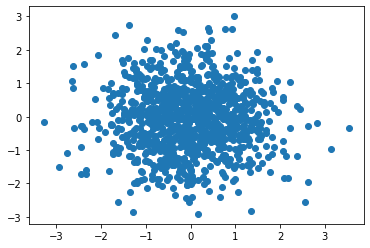

In [2]:
# Generate a synthetic dataset, first for the simple case of d = 1.
d = 1
n = 1024
X = np.random.randn(d, n)
Y = np.random.randn(n)
plt.scatter(X,Y)
plt.show()

In [3]:
# Solve the normal equations to find the true optimum
A = np.mean([np.outer(X[:, i], X[:, i]) for i in range(n)], axis=0)
b = np.mean([X[:, i] * Y[i] for i in range(n)], axis=0)
w_opt = np.linalg.inv(A) @ b
print(w_opt)

[-0.01553517]


Define functions for the loss and its gradient. Two versions are provided, vector and matrix, to compare their efficiency.

In [4]:
# component loss function - vector version
def loss_fi(w, xi, yi):
    return (np.dot(xi,w) - yi)**2/2

# component gradient function- vector version
def grad_fi(w, xi, yi):
    return xi*(np.dot(xi,w) - yi)

# total loss function - vector version
def loss_f(w, X, Y):
    (d, n) = X.shape
    return np.mean([loss_fi(w, X[:,i], Y[i]) for i in range(n)])

# total gradient function - vector version
def grad_f(w, X, Y):
    (d,n) = X.shape
    return np.mean([grad_fi(w, X[:,i], Y[i]) for i in range(n)])

# total loss function - matrix version
def matrix_loss_f(w, X, Y):
    (d,n) = X.shape
    return np.sum((np.dot(X.T,w) - Y)**2)/(2*n)

# total gradient function - matrix version
def matrix_grad_f(w, X, Y):
    return np.dot(X,(np.dot(X.T,w) - Y))/n

Compare the two approaches for computing the loss.

In [5]:
w = np.random.randn(d)

print(loss_f(w, X, Y))
print(matrix_loss_f(w, X, Y))

print(grad_f(w, X, Y))
print(matrix_grad_f(w, X, Y))

0.6030021107320747
0.6030021107320747
-0.4508989445731611
[-0.45089894]


In [6]:
%timeit -r 1 -n 1 grad_f(w, X, Y)
%timeit -r 1 -n 1 matrix_grad_f(w, X, Y)
#6.29e-3/101e-6

8.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
15 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The matrix version is approximately 60X faster and requires 18X less storage.

We can now compare  Gradient Descent (GD) and Stochastic Gradient (SGD).  We will  measure the distance to the (known) optimum, `w_opt`, at each step.

In [7]:
#import numpy as np

def gradient_descent(w0, X, Y, w_opt, alpha, num_iters):
    error = np.zeros(num_iters)
    loss = np.zeros(num_iters)
    w = w0
    for t in range(num_iters):
        w = w - alpha * matrix_grad_f(w, X, Y)
        error[t] = np.linalg.norm(w - w_opt)
        loss[t] = matrix_loss_f(w, X, Y)
    return (error, loss)

def stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters):
    d, n = X.shape
    error = np.zeros(num_iters)
    loss = np.zeros(num_iters)
    w = w0
    for t in range(num_iters):
        i = np.random.randint(0, n)
        w = w - alpha * grad_fi(w, X[:,i], Y[i])
        error[t] = np.linalg.norm(w - w_opt)
        loss[t] = matrix_loss_f(w, X, Y)
    return (error, loss)

We fix:
- an initial guess far from the true solution
- a step-size, or learning rate $\alpha=0.1$
- a limit of 1000 iterations

In [8]:
w0 = [5.0]
alpha = 0.1
num_iters = 1000
[gd_dist, gd_loss] = gradient_descent(w0, X, Y, w_opt, alpha, num_iters)
[sgd_dist, sgd_loss] = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters)

## Plots

We plot the errors for the two methods, as a function of the iteration number.


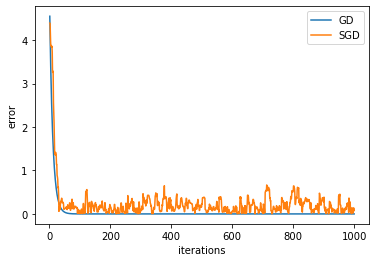

In [9]:
plt.plot(range(1,num_iters+1), gd_dist, label="GD");
plt.plot(range(1,num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations");
plt.ylabel("error");
plt.legend();
plt.show()

A log plot will be better here.

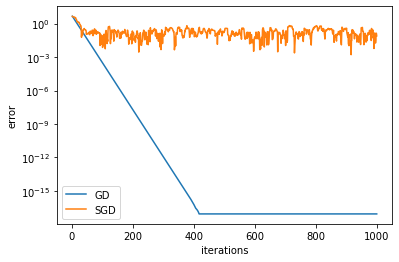

In [10]:
plt.semilogy(range(1, num_iters+1), gd_dist, label="GD")
plt.semilogy(range(1, num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations")
plt.ylabel("error")
plt.legend()
plt.show()

We observe that the Stochastic Gradient does not descend below an error of approximately $0.01.$ This the well-known phenomenon of "noise ball" convergence. It cam be remedied by adjusting the learning rate--see below.

We now examine the evolution of the loss itself.

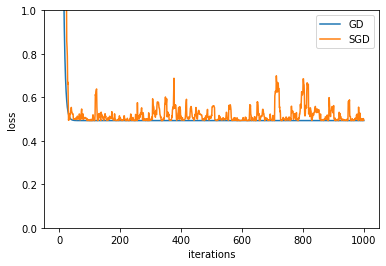

In [11]:
plt.plot(range(1, num_iters+1), gd_loss, label="GD")
plt.plot(range(1, num_iters+1), sgd_loss, label="SGD")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.ylim((0, 1))
plt.show()

The loss has an asymptotic value.

We now consider a much higher dimension, $d=1000.$ In higher dimensions, the SGD converges more slowly than SD.

In [12]:
d = 100;
n = 1024;
X = np.random.randn(d, n)
Y = np.random.randn(n)
# Solve the normal equations to find the true optimum
A = np.mean([np.outer(X[:, i], X[:, i]) for i in range(n)], axis=0)
b = np.mean([X[:, i] * Y[i] for i in range(n)], axis=0)
w_opt = np.linalg.inv(A) @ b

In [13]:
w0 = 2*np.random.randn(100)
alpha = 0.01
num_iters = 5000
gd_dist, gd_loss = gradient_descent(w0, X, Y, w_opt, alpha, num_iters)
sgd_dist, sgd_loss = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters)

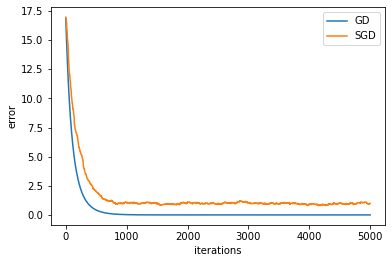

In [14]:
plt.plot(range(1,num_iters+1), gd_dist, label="GD");
plt.plot(range(1,num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations");
plt.ylabel("error");
plt.legend();
plt.show()

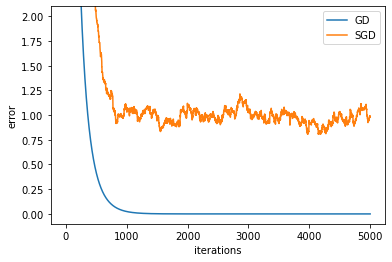

In [15]:
plt.plot(range(1,num_iters+1), gd_dist, label="GD");
plt.plot(range(1,num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations");
plt.ylabel("error");
plt.legend()
plt.ylim((-0.1, 2.1))
plt.show()

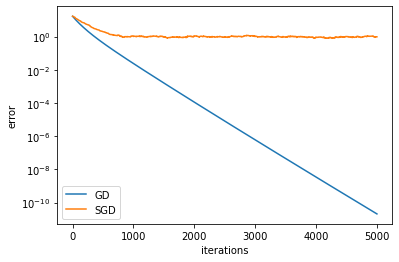

In [16]:
plt.semilogy(range(1, num_iters+1), gd_dist, label="GD")
plt.semilogy(range(1, num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations")
plt.ylabel("error")
plt.legend()
plt.show()

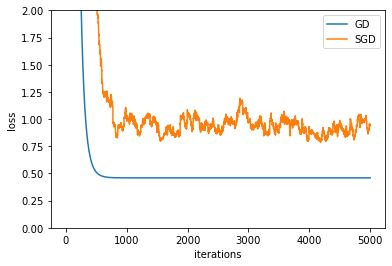

In [17]:
plt.plot(range(1, num_iters+1), gd_loss, label="GD")
plt.plot(range(1, num_iters+1), sgd_loss, label="SGD")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.ylim((0, 2))
plt.show()

## Influence of Learning Rate $\alpha$

To study the influence of the learning rate, we reduce it from $\alpha=0.01$ to $\alpha=0.001$ and rerun the optimization.

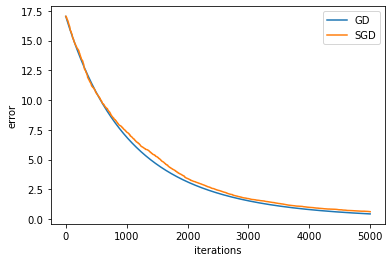

In [18]:
alpha = 0.001;
num_iters = 5000;
gd_dist, gd_loss = gradient_descent(w0, X, Y, w_opt, alpha, num_iters)
sgd_dist, sgd_loss = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters)
#
plt.plot(range(1,num_iters+1), gd_dist, label="GD");
plt.plot(range(1,num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations");
plt.ylabel("error");
plt.legend();
plt.show()
#ylim([-0.1,2.1]);

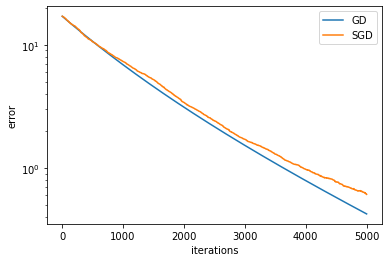

In [19]:
plt.semilogy(range(1, num_iters+1), gd_dist, label="GD")
plt.semilogy(range(1, num_iters+1), sgd_dist, label="SGD")
plt.xlabel("iterations")
plt.ylabel("error")
plt.legend()
plt.show()

In [20]:
%timeit -r 4 -n 1 gradient_descent(w0, X, Y, w_opt, alpha, num_iters)
%timeit -r 4 -n 1 stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters)

501 ms ± 63.4 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
281 ms ± 34.4 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


# Conclusion

1. By reducing the learning rate, the stochastic method has "caught up" and the errors are practically indistinguishable.
2. The stochastic gradient is faster by a factor of approximately $1.8$